# Imports

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
import numpy as np
import torch
from torchvision.utils import save_image
from torchvision import transforms
import torch
import numpy as np
from torch.autograd import Variable
from matplotlib import pyplot as plt

# Model

In [47]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

In [48]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x

In [4]:
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)

In [5]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Style Transformation

In [6]:
def style_transform(image_size=None):
    """ Transforms for style image """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform


def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors

In [7]:
dataset_path = './Images\Room_SetA'
styles = ['./Styles/cuphead.jpg', './Styles/mosaic.jpg', './Styles/starry_night.jpg']

In [31]:
os.makedirs("images/outputs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = style_transform()

Using device: cuda


# Pre-trained models

In [33]:
models = ['./Models/cuphead_10000.pth', './Models/mosaic_10000.pth', './Models/starry_night_10000.pth']

In [36]:
transformer1 = TransformerNet().to(device)
transformer1.load_state_dict(torch.load(models[0]))
transformer1.eval()

transformer2 = TransformerNet().to(device)
transformer2.load_state_dict(torch.load(models[1]))
transformer2.eval()

transformer3 = TransformerNet().to(device)
transformer3.load_state_dict(torch.load(models[2]))
transformer3.eval()

TransformerNet(
  (model): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): ReflectionPad2d((4, 4, 4, 4))
        (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
      )
      (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      )
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (3): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (block): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            

# Testing on the given image

In [ ]:
def show_transformation(img, stylized_img, style):
    plt.figure(figsize=(18, 18))
    plt.subplot(1, 3, 1)
    plt.imshow(Image.open(img))
    plt.title("Original Image", fontsize=20)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(stylized_img.squeeze().numpy(), (1, 2, 0)))
    plt.title("Stylized Image", fontsize=20)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(Image.open(style))
    plt.title("Style Image", fontsize=20)
    plt.axis('off')

    plt.show()

In [63]:
img = './Masterlayer_Event221_SetA.png'

In [64]:
image_tensor = Variable(transform(Image.open(img))).to(device)
image_tensor = image_tensor.unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


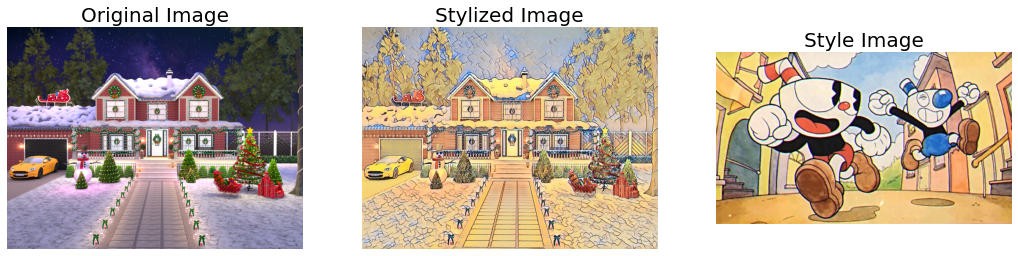

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


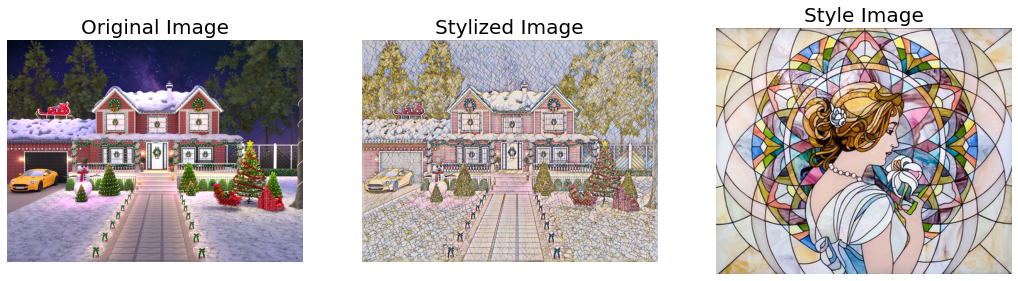

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


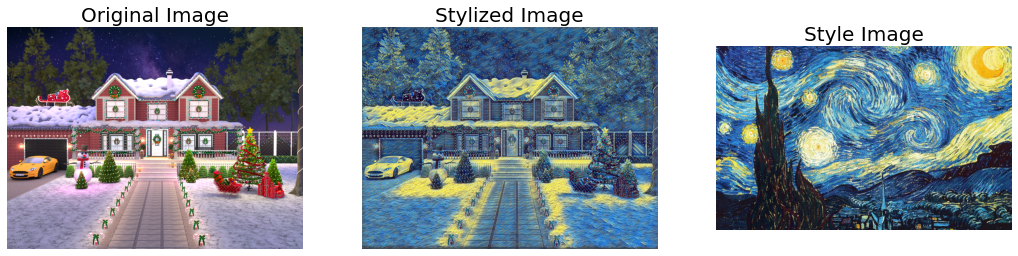

In [45]:
transformers = [transformer1, transformer2, transformer3]
for i in range(3):
    with torch.no_grad():
        stylized_image = denormalize(transformers[i](image_tensor)).cpu()
    style_name = models[i].split('/')[-1].split('.')[0]
    save_image(stylized_image, f"images/outputs/stylized-{style_name}-{(img.split('/')[-1]).split('.')[0]}.png")
    show_transformation(img, stylized_image, styles[i])

# Transforming all images from the assets folder

In [54]:
assets = os.listdir(dataset_path)

for asset in assets[1:]:
    # transform image
    print(os.path.join(dataset_path, asset))
    image_tensor = Variable(transform(Image.open(os.path.join(dataset_path, asset)))).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    # stylize image
    with torch.no_grad():
        stylized_image = denormalize(transformer1(image_tensor)).cpu()
    style_name = models[0].split('/')[-1].split('.')[0]
    save_image(stylized_image, f"images/outputs/{style_name}/trans_{asset}")



./Images\Room_SetA\BG.png


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0